<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Assignment_3_2_OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load a reduced dataset for transfer learning that:
    1. Only contains the classes „ship“ and „truck“
    2. Only contains the first 50 images of the original dataset that are either „ship“ or „truck“.
2. Apply transfer learning by loading the model that was trained on the eight CIFAR classes
(Notebook 1) and do the following experiments:
    1. Re-initalize the last fully connected layer to predict on two classes.
    2. Train on the 50 training images (as on the last slide) with the model using two different
approaches:
        1. Fine-tune all parameters (i.e. do not freeze parameters but reduce learning rate).
        2. Freeze all parameters expect the ones from the last fc-layer.
    3. Calculate the accuracy for both approaches on 50 test images.
3. Do the same as in step 2 but use the pre-trained network resnet18 from the torch vision library.
Compare the results.
4. Resnet18 was pre-trained on the image net data, which has an image resolution of 224x224.
However, Resnet18 still works on other solutions because it uses an adaptive pooling layer
before the fc-layer (see discussion here). Try to see if you can improve the results by resizing
the CIFAR images to 224x224 before passing it to the Resnet.
5. Bonus: Check how the transfer learning approach works with the pre-trained VGG16 model.

#Import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Data

In [3]:
class NewCifar(Dataset):

    def __init__(self, oldCifar):
        self.newCifar = []

        counterTruck=0
        counterShip=0

        for i in range(len(oldCifar)):
            if (oldCifar.targets[i] == 8) and (counterTruck < 50):
                counterTruck += 1
                oldCifar.targets[i] = 0
                self.newCifar.append(oldCifar[i])
            if (oldCifar.targets[i] == 9) and (counterShip < 50):
                counterShip += 1
                oldCifar.targets[i] = 1
                self.newCifar.append(oldCifar[i])


    def __len__(self):
        return len(self.newCifar) # 1000 per calss

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx= idx.tolist()

        return self.newCifar[idx]

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform))


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = NewCifar(torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform))
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('ship', 'truck')

print(len(testset))

Files already downloaded and verified
Files already downloaded and verified
100


#Data

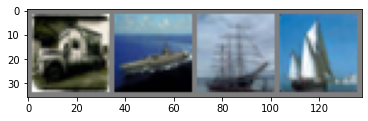

truck  ship  ship  ship


In [5]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#Load Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def load_images(freeze = False):
    model = Net()

    PATH = '/content/drive/My Drive/a3/cifar_net.pth'
    model.load_state_dict(torch.load(PATH))

    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        
    num_ftrs = model.fc3.in_features
    model.fc3 = nn.Linear(num_ftrs, 2)



84
